# DCGAN - TensorFlow using CIFAR10

### 작성자: 고려대학교 수학과 석사과정 최선묵

[References]  
- [Goodfellow's GAN Paper Link](https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf)  
- [DCGAN Paper Link](https://arxiv.org/pdf/1511.06434.pdf)


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, GlobalAveragePooling2D
from tensorflow.keras.activations import relu, tanh
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam


## Data Preparation

In [4]:
# Download MNIST dataset in numpy array format
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Reshape it into 4-dim'l tensor and convert the type for `int` into `float`
train_images = X_train.reshape((X_train.shape[0], 32, 32, 3)).astype('float32')
test_images = X_test.reshape((X_test.shape[0], 32, 32, 3)).astype('float32')

data_images = np.concatenate((train_images, test_images), axis=0)

# Set the pixel values from -1 to 1
data_images = (data_images/255.0) * 2 - 1

# Shuffle and seperate into batches
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(data_images).shuffle(data_images.shape[0]).batch(BATCH_SIZE)

170498071/170498071 [==============================] - 16s 0us/step


## Deep Convolutional GANs

### Architecture guidelines for stable Deep Convolutional GANs

- Replace any pooling layers with `strided convolutions` (discriminator) and `fractional-strided convolutions` (generator).
- Use `BatchNormaliziation` in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use `ReLU` activation in `generator` for all layers except for the output, which uses Tanh.
- Use `LeakyReLU` activation in the `discriminator` for all layers.

In [6]:
## Hyperparameters
latent_dim = 100

EPOCHS = 80
LR = 2e-4
BETA1 = 0.5 # for Adam optimizer


### Weight Initialization

In [7]:
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)

### Generator

In [8]:
def create_generator(input_size=latent_dim):
    input_tensor = Input(shape=(input_size))

    x = Reshape(target_shape=(2,2,25))(input_tensor)
    x = UpSampling2D(size=(2,2), interpolation='bilinear')(x)
    x = Conv2D(256, kernel_size=(5,5), strides=1, padding='same', 
               use_bias=False, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.0)

    x = UpSampling2D(size=(2,2), interpolation='bilinear')(x)
    x = Conv2D(128, kernel_size=(5,5), strides=1, padding='same', 
               use_bias=False, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.0)

    x = UpSampling2D(size=(2,2), interpolation='bilinear')(x)
    x = Conv2D(64, kernel_size=(5,5), strides=1, padding='same', 
               use_bias=False, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.0)

    x = UpSampling2D(size=(2,2), interpolation='bilinear')(x)
    x = Conv2D(32, kernel_size=(5,5), strides=1, padding='same', 
               use_bias=False, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.0)
    
    x = Conv2D(3, kernel_size=(3,3), strides=1, padding='same', 
               use_bias=True, activation='tanh', kernel_initializer=initializer)(x)

    model = Model(inputs=input_tensor, outputs=x)
    
    return model

In [9]:
g_model = create_generator()
g_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 25)          0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 4, 4, 25)         0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 256)         160000    
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 256)        1024      
 ormalization)                                                   
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 4, 4, 256)         0     

### Discriminator

In [10]:
def create_discriminator(input_shape=(32,32,3)):

    input_tensor = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3,3), strides=2, padding='same', 
               use_bias=False, kernel_initializer=initializer)(input_tensor)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.2)

    x = Conv2D(64, kernel_size=(3,3), strides=2, padding='same', 
               use_bias=False, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.2)

    x = Conv2D(128, kernel_size=(3,3), strides=2, padding='same', 
               use_bias=False, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.2)

    x = Conv2D(256, kernel_size=(3,3), strides=1, padding='same', 
               use_bias=False, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.2)

    x = GlobalAveragePooling2D()(x)

    x = Dense(units=64, use_bias=False, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.2)
    x = Dense(units=1, use_bias=True, activation='sigmoid', kernel_initializer=initializer)(x)

    model = Model(inputs=input_tensor, outputs=x)

    return model
    


In [11]:
d_model = create_discriminator()
d_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 32)        864       
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 tf.nn.leaky_relu (TFOpLambd  (None, 16, 16, 32)       0         
 a)                                                              
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 64)          18432     
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 64)         256 

### GAN model

In [12]:
class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator, noise_size=latent_dim, d_iter=1):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.noise_size = noise_size
        self.d_iter = d_iter
        self.img_list = []

    def compile(self, d_optimizer, g_optimizer):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    def create_gen_input(self, batch_size):
        noise = tf.random.normal([batch_size, self.noise_size])
        return noise

    def train_step(self, real_img):
        
        criterion = BinaryCrossentropy()
        batch_size = tf.shape(real_img)[0]
        
        # Train Discriminator d_iter times with fixed generator.
        for _ in range(self.d_iter):
            with tf.GradientTape() as d_tape: 
                self.discriminator.trainable = True
                self.generator.trainable = False
                d_tape.watch(self.discriminator.trainable_variables)

                # Train discriminator using half batch real images. Real images have labels 1.
                real_label = tf.ones((batch_size, 1))
                d_real_output = self.discriminator(real_img)
                d_loss_real = criterion(real_label, d_real_output)

                # Train discriminator using half batch fake images. Fake images have labels 0. 
                fake_label = tf.zeros((batch_size, 1))

                # Create generator input 
                noise = self.create_gen_input(batch_size=batch_size)

                # Create fake image batch
                fake_img = self.generator(noise)
                d_fake_output = self.discriminator(fake_img)
                d_loss_fake = criterion(fake_label, d_fake_output)

                # Total Loss of Discriminator 
                d_loss = d_loss_real + d_loss_fake

            # Compute gradients
            d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)

            # Optimize
            self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        # Train Generator with fixed discriminator.
        with tf.GradientTape() as g_tape:
            self.discriminator.trainable = False
            self.generator.trainable = True
            g_tape.watch(self.generator.trainable_variables)
            
            # Train generator using fake batch images. Fake images have labels 1 for generators.
            fake_img = self.generator(noise)
            d_fake_output = self.discriminator(fake_img)
            g_loss = criterion(real_label, d_fake_output)
        
        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables) # Compute gradients
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables)) # Optimize

        return {"d_loss_real": d_loss_real, "d_loss_fake": d_loss_fake, "g_loss": g_loss}



In [13]:
gan = GAN(generator=g_model, discriminator=d_model)

gan.compile(d_optimizer=Adam(learning_rate=LR, beta_1 = BETA1, beta_2=0.999),
            g_optimizer=Adam(learning_rate=LR, beta_1 = BETA1, beta_2=0.999)
            )

history = gan.fit(train_dataset, epochs=EPOCHS)

Epoch 1/80
469/469 [==============================] - 34s 51ms/step - d_loss_real: 0.6698 - d_loss_fake: 0.7334 - g_loss: 0.7838
Epoch 2/80
469/469 [==============================] - 23s 49ms/step - d_loss_real: 0.7014 - d_loss_fake: 0.5810 - g_loss: 1.1692
Epoch 3/80
469/469 [==============================] - 23s 49ms/step - d_loss_real: 0.7010 - d_loss_fake: 0.6841 - g_loss: 0.7237
Epoch 4/80
469/469 [==============================] - 24s 50ms/step - d_loss_real: 0.6957 - d_loss_fake: 0.6876 - g_loss: 0.7149
Epoch 5/80
469/469 [==============================] - 24s 51ms/step - d_loss_real: 0.6916 - d_loss_fake: 0.6912 - g_loss: 0.7213
Epoch 6/80
469/469 [==============================] - 24s 51ms/step - d_loss_real: 0.6811 - d_loss_fake: 0.7046 - g_loss: 0.6893
Epoch 7/80
469/469 [==============================] - 24s 50ms/step - d_loss_real: 0.6818 - d_loss_fake: 0.7036 - g_loss: 0.6837
Epoch 8/80
469/469 [==============================] - 24s 50ms/step - d_loss_real: 0.6861 - d_los

In [14]:
# Save trained models

g_model.save('saved_models/generator')
d_model.save('saved_models/discriminator')

In [15]:
# Load trained models

g_model = tf.keras.models.load_model('saved_models/generator')
d_model = tf.keras.models.load_model('saved_models/discriminator')

In [22]:
# from google.colab import files

# files.download('saved_models/generator/saved_model.pb')
# files.download('saved_models/generator/variables/variables.index')
# files.download('saved_models/generator/variables/variables.data-00000-of-00001')

# files.download('saved_models/discriminator/saved_model.pb')
# files.download('saved_models/discriminator/variables/variables.index')
# files.download('saved_models/discriminator/variables/variables.data-00000-of-00001')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Test

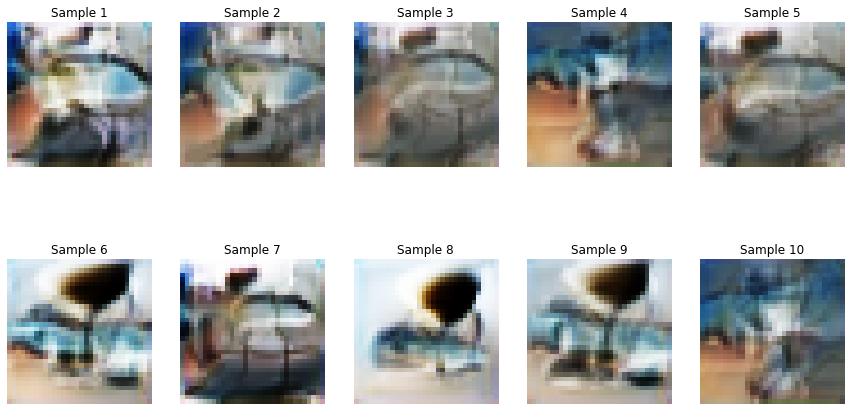

In [18]:
noise = tf.random.normal([10, latent_dim], seed=127)
generated_images = g_model(noise)
generated_images = (generated_images + 1)/2 # convert the values from [-1,1] to [0,1] for plots

plt.rcParams['figure.figsize'] = (15.0, 8.0)

rows = 2
columns = 5

for i in range(10) : 
    image_index = i+1      # image index 
    title = "Sample {}".format(image_index) # image title
    plt.subplot(rows, columns, image_index) # subplot 
    plt.title(title)   # title 
    plt.axis('off')
    plt.xticks([])  # x = None 
    plt.yticks([])  # y = None
    plt.imshow(generated_images[i])  
plt.show()
